# Disaster Tweets Recognition using RNNs
## Purpose
The purpose is to leverage Recurring Neural Networks (RNNs) to categorize tweets announcing a disaster v. regular tweets.

*The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).*

Author: [Bruno Velleca](https://github.com/brucamail/MSCS-Machine-Learning/tree/main)

## About the data
The data is sourced from Kaggle's [Natural Language Processing with Disaster Tweets competition](https://www.kaggle.com/c/nlp-getting-started/overview).
The dataset is split in training and testing, totalling 10k observations.

Every observation has 5 columns: id, keyword, location, text and target. We'll focus on leveraging the text content to predict the target (0: no disaster, 1: disaster).

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Exploratory Data Analysis (EDA)
### Data Visualization and Cleaning
We will drop the keyword and location columns:

In [3]:
#importing the database & dropping the irrelevant columns
df_tweets = pd.read_csv('train.csv')
df_tweets.drop(['keyword', 'location'], axis=1, inplace=True)
df_tweets.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#counting the length of text & title
df_tweets['text_length'] = df_tweets['text'].astype(str).apply(lambda x: len(x.split()))

twwet_count = df_tweets['target'].value_counts()
total_count = df_tweets.shape[0]
twwet_count['Total'] = total_count

# avg word count per article per target
word_count = df_tweets.groupby('target')['text_length'].mean()
word_count['Total'] = df_tweets['text_length'].mean()

#shortest word count per target
min_word_count = df_tweets.groupby('target')['text_length'].min()
min_word_count['Total'] = df_tweets['text_length'].min()

#longest word count per target
max_word_count = df_tweets.groupby('target')['text_length'].max()
max_word_count['Total'] = df_tweets['text_length'].max()

#building a summary table
summary_table = pd.concat([twwet_count, word_count.map('{:.1f}'.format), min_word_count, max_word_count], axis=1)
summary_table.columns = ['Article Count', 'Avg Word Count', 'Min Word Count', 'Max Word Count']
summary_table

,Article Count,Avg Word Count,Min Word Count,Max Word Count
target,,,,
0,4342,14.7,1,31
1,3271,15.2,2,30
Total,7613,14.9,1,31


In [5]:
#checking the number of chars in a tweet
df_tweets['char_count'] = df_tweets['text'].astype(str).apply(len)

#avg char count
char_count = df_tweets.groupby('target')['char_count'].mean()
char_count['Total'] = df_tweets['char_count'].mean()

#shortest char count
min_char_count = df_tweets.groupby('target')['char_count'].min()
min_char_count['Total'] = df_tweets['char_count'].min()

#longest
max_char_count = df_tweets.groupby('target')['char_count'].max()
max_char_count['Total'] = df_tweets['char_count'].max()

#summary_table
summary_table_char = pd.concat([char_count.map('{:.1f}'.format), min_char_count, max_char_count], axis=1)
summary_table_char.columns = ['Avg Char Count', 'Min Char Count', 'Max Char Count']
summary_table_char


,Avg Char Count,Min Char Count,Max Char Count
target,,,
0,95.7,7,157
1,108.1,14,151
Total,101.0,7,157


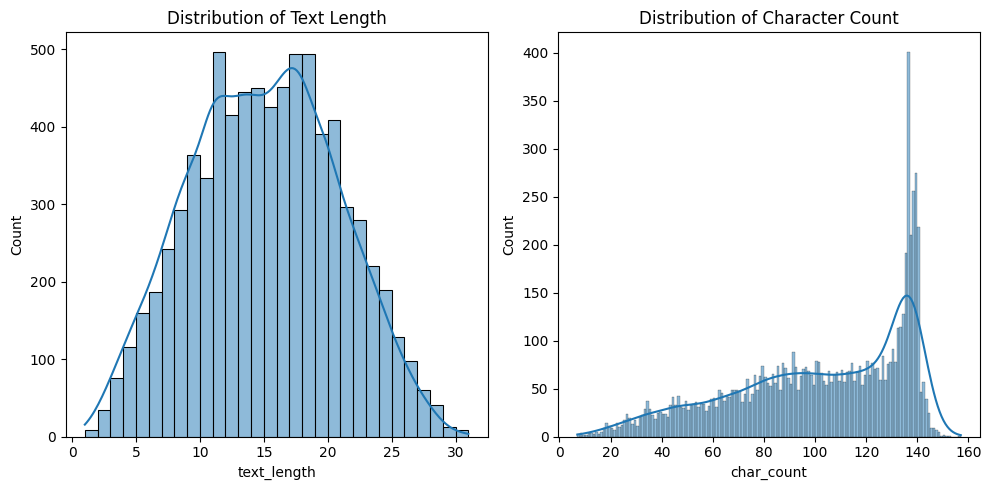

In [6]:
#plotting the distribution of tweets
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(data=df_tweets, x='text_length', label='Text', kde=True, ax=ax[0], binwidth=1)
sns.histplot(data=df_tweets, x='char_count', label='Text', kde=True, ax=ax[1], binwidth=1)
ax[0].set_title('Distribution of Text Length in numbers of Words')
ax[1].set_title('Distribution of Character Count')
plt.tight_layout()
plt.show()

An interesting thing to notice is the spike in the number of tweets with ~140 chars. This is due to the limitation of 140 charachters that twitter had until late 2017. The limit increased to 280 chars in 2018. Paying users were allowed to post longer than 140 chars.

In [12]:
top_chars = df_tweets['char_count'].value_counts().head(5)
top_chars_df = pd.DataFrame(top_chars).reset_index()
top_chars_df

,char_count,count
0,136,401
1,139,275
2,138,256
3,140,218
4,137,210


In [15]:
#group the tweets with length 136 by text
top136 = df_tweets[df_tweets['char_count'] >= 136]['text'].value_counts()
top136_df = pd.DataFrame(top136).reset_index()
top136_df.head(8)

,text,count
0,11-Year-Old Boy Charged With Manslaughter of T...,10
1,#Bestnaijamade: 16yr old PKK suicide bomber wh...,6
2,VIDEO: 'We're picking up bodies from water': R...,4
3,Madhya Pradesh Train Derailment: Village Youth...,3
4,Who is bringing the tornadoes and floods. Who ...,3
5,#Allah describes piling up #wealth thinking it...,3
6,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,2
7,that exploded &amp; brought about the\nbeginni...,2


By looking at the char count it is possible to notice repeated tweets. We'll first check if they are categorized with the samee target and if so, we'll go ahead and remove repeated observations from the dataset.

In [17]:
#checking if the repeated instances have the same classification using regex
r = '11-Year-Old Boy Charged With Manslaughter'
repeated_tweet = df_tweets[df_tweets['text'].str.contains(r, regex=True)]
repeated_tweet

,id,text,target,text_length,char_count
3578,5113,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3589,5127,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3591,5130,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3597,5137,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3600,5140,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3603,5144,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3604,5145,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3610,5153,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3613,5157,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136
3614,5159,11-Year-Old Boy Charged With Manslaughter of T...,1,20,136


In [23]:
#removing the repeated tweets from the data base
df_tweets.drop_duplicates(subset=['text'], keep='first', inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7503 non-null   int64 
 1   text         7503 non-null   object
 2   target       7503 non-null   int64 
 3   text_length  7503 non-null   int64 
 4   char_count   7503 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 351.7+ KB


After removing duplicates, we are left with 7503 observations (110 duplicated entries were removed).

## Feature Cleaning (Text Processing & Normalization)

We'll clean the data by:


*   Lowercasing all words;
*   Removing special characters;
*   Removing numbers;
*   Removing stopwords;
*   Removing URLs;
Notice that the final cleaning function is a consequence of running this cleaning process several times and tackling words and regular expressions as seen in the word charts below.

In [39]:
import spacy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    if not isinstance(text, str):
        return ""
    # Lowercase and remove special characters and numbers
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)

    # removing html and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r'<.*?>','',text)

    # Tokenize using spaCy and lemmatize
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]

    specific_words = ['I','i','http','co','-','_','û']

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(specific_words)
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply the new preprocessing function
df_tweets['cleaned_text'] = df_tweets['text'].apply(clean_text_spacy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's check how the cleaned text compares to the original tweet text:

In [50]:
df_tweets[['text','cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order ca...
4,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby alaska smoke wildfire pour...


<ipython-input-51-2e95bd474492>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-51-2e95bd474492>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


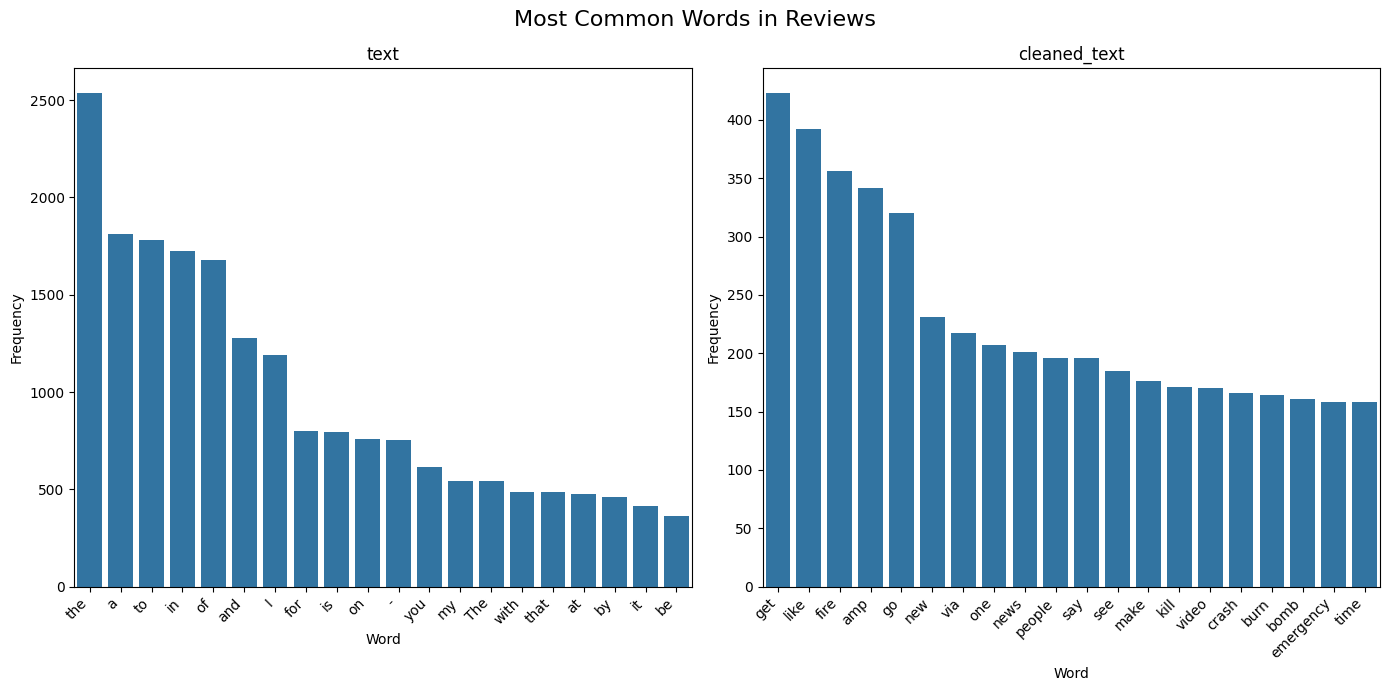

Number of words in text: 31924
Number of words in cleaned_text: 18645


In [51]:
#dictionary of most common words
relevant_words ={}
columns = ['text', 'cleaned_text']

for column in columns:
  relevant_words[column] = {}
  for word in df_tweets[column].str.split().explode():
    if word not in relevant_words[column]:
      relevant_words[column][word] = 1
    else:
      relevant_words[column][word] += 1
  relevant_words[column] = {k: v for k, v in sorted(relevant_words[column].items(), key=lambda item: item[1], reverse=True)}
  relevant_words[column] = list(relevant_words[column].items())
  relevant_words[column] = pd.DataFrame(relevant_words[column], columns=['Word', 'Frequency'])


#plotting the most common word before and after cleaning
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Most Common Words in Reviews', fontsize=16)

for i, column in enumerate(columns):
    ax = axs[i]
    sns.barplot(data=relevant_words[column].head(20), x='Word', y='Frequency', ax=ax)
    ax.set_title(column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#count of words per columns
for column in columns:
  print(f"Number of words in {column}: {len(relevant_words[column])}")


With the cleaning process we were able to reduce the words by almost half (from 32k to 18k), removing stopwords and other not value added terms. Anothgher interesting way to look at the data is by looking at bigrams. The char below shows how the most common bigrams are now relevant for our analysis afte the cleaning of the data.

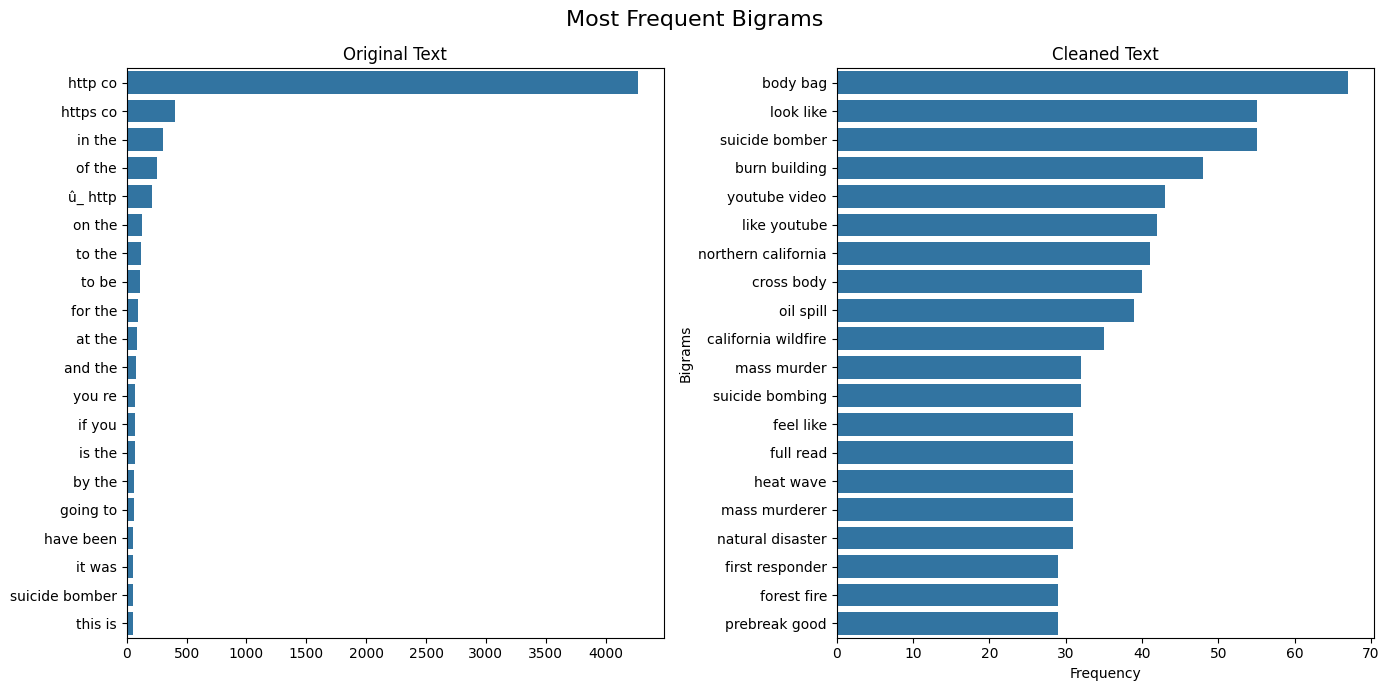

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( ngram_range=(2,2), max_features=20)
text_counter = vectorizer.fit_transform(df_tweets['text'])
text_freq = dict(zip(vectorizer.get_feature_names_out(), text_counter.toarray().sum(axis=0)))
text_freq = {k: v for k, v in sorted(text_freq.items(), key=lambda item: item[1], reverse=True)}

cleaned_counter = vectorizer.fit_transform(df_tweets['cleaned_text'])
cleaned_freq = dict(zip(vectorizer.get_feature_names_out(), cleaned_counter.toarray().sum(axis=0)))
cleaned_freq = {k: v for k, v in sorted(cleaned_freq.items(), key=lambda item: item[1], reverse=True)}

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Most Frequent Bigrams', fontsize=16)

sns.barplot(x=list(text_freq.values()), y=list(text_freq.keys()), ax=axs[0])
axs[0].set_title('Original Text')

sns.barplot(x=list(cleaned_freq.values()), y=list(cleaned_freq.keys()), ax=axs[1])
axs[1].set_title('Cleaned Text')

plt.xlabel("Frequency")
plt.ylabel("Bigrams")

plt.tight_layout()
plt.show()


## Building the Models
To build and train the model, I'm following and adapting TensorFlow's Text classification [tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn).

For each model we will:
1. Split the data in training and validattion sets
2. Create an encoder
3. Build and Compile the RNN Model (LSTM)

The motivation to building a model leveraging the text that has not been cleaned comes from the fact that the TensorFlow tutorial does no data cleaning of the input data. Adittionally, when looking for more information of the topic I found that doing standard preprocessing steps might cause some of the valuable information for the model to be lost.

### Model A: Using the Cleaned Text column

In [84]:
#dowloading the df_tweets dataset
# df_tweets.to_csv('df_tweets.csv', index=False)

In [149]:
#splitting the 'cleaned_text' in training & validation data
from sklearn.model_selection import train_test_split
X_clean = df_tweets['cleaned_text']
y = df_tweets['target']
X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size = 0.2, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

#aux function for plotting the charts
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [145]:
#creating the encoder
import tensorflow_datasets as tfds
import tensorflow as tf

VOCAB_SIZE = 1500
clean_encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
clean_encoder.adapt(X_train)

In [146]:
#building the model - using LSTM and relu activation function
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

modelA = tf.keras.Sequential([
    clean_encoder,
    tf.keras.layers.Embedding(
        input_dim=len(clean_encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

#compiling the model using Adam optimizer with 0.0001 as the learning rate
modelA.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [147]:
#training the model
historyA = modelA.fit(X_train.to_numpy(), y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    validation_steps=30)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5775 - loss: 0.6872 - val_accuracy: 0.5823 - val_loss: 0.6635
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5920 - loss: 0.6296 - val_accuracy: 0.7642 - val_loss: 0.5217
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7916 - loss: 0.4484 - val_accuracy: 0.7715 - val_loss: 0.5247
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.8249 - loss: 0.3970 - val_accuracy: 0.7795 - val_loss: 0.5163
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8406 - loss: 0.3652 - val_accuracy: 0.7821 - val_loss: 0.5318
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8508 - loss: 0.3481 - val_accuracy: 0.7841 - val_loss: 0.5420
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8528 - loss: 0.3343 - val_accuracy: 0.7861 - val_loss: 0.5458
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8697 - loss: 0.3085 - val

In [150]:
test_loss, test_acc = modelA.evaluate(X_val,y_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7831 - loss: 0.5916
Test Loss: 0.5850001573562622
Test Accuracy: 0.7894737124443054


(0.0, 0.7003835767507554)

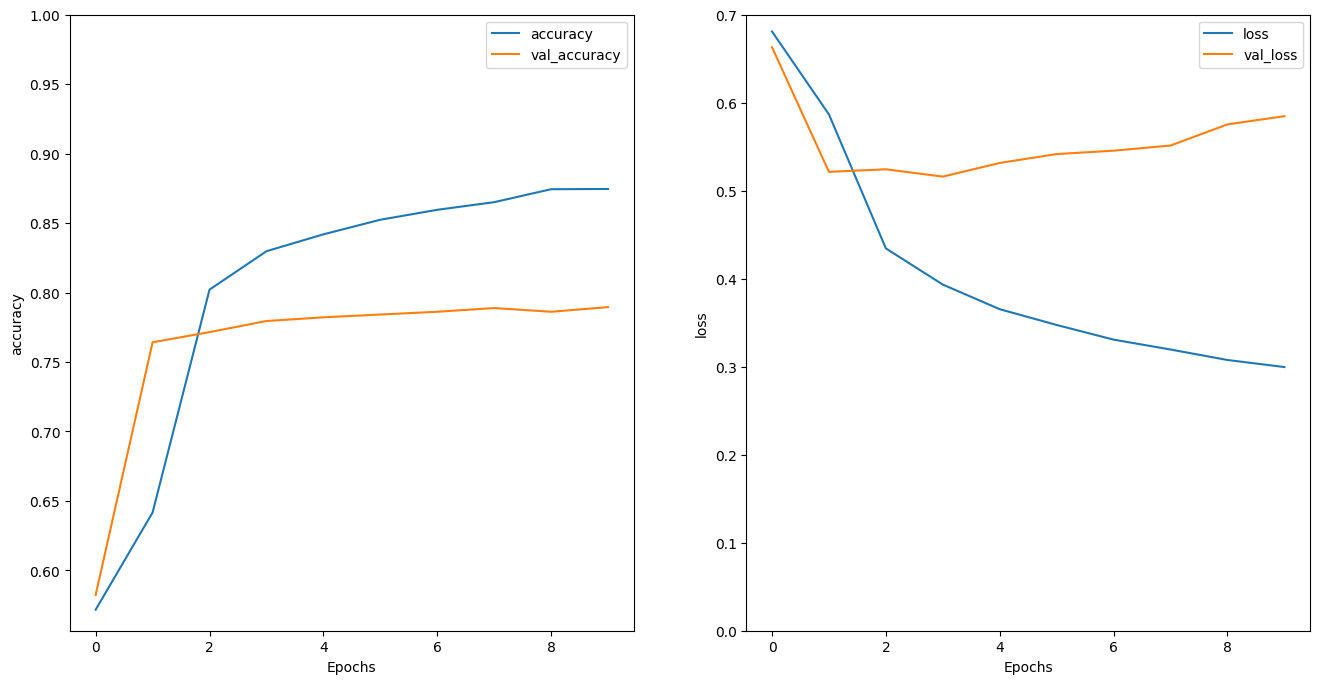

In [151]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(historyA, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(historyA, 'loss')
plt.ylim(0, None)

### Model B: Using the Standard Text column

In [136]:
#splitting the 'text' in training & validation data
X_regular = df_tweets['text']
y = df_tweets['target']
X_train, X_val, y_train, y_val = train_test_split(X_regular, y, test_size = 0.2, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()


In [121]:
VOCAB_SIZE = 1500
reg_encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
reg_encoder.adapt(X_train)

In [122]:
reg_model = tf.keras.Sequential([
    reg_encoder,
    tf.keras.layers.Embedding(
        input_dim=len(reg_encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

#compiling the model using Adam optimizer with 0.0001 as the learning rate
reg_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [123]:
historyB = reg_model.fit(X_train.to_numpy(), y_train, epochs=10,
                    validation_data=(X_val.to_numpy(), y_val),
                    validation_steps=30)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5727 - loss: 0.6873 - val_accuracy: 0.5823 - val_loss: 0.6615
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5922 - loss: 0.6222 - val_accuracy: 0.7542 - val_loss: 0.5469
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7965 - loss: 0.4472 - val_accuracy: 0.7668 - val_loss: 0.5157
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8275 - loss: 0.3965 - val_accuracy: 0.7748 - val_loss: 0.5055
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8398 - loss: 0.3685 - val_accuracy: 0.7801 - val_loss: 0.5120
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8478 - loss: 0.3513 - val_accuracy: 0.7755 - val_loss: 0.5197
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8489 - loss: 0.3477 - val_accuracy: 0.7742 - val_loss: 0.5425
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8621 - loss: 0.3310 - val_

In [137]:
test_loss, test_acc = reg_model.evaluate(X_val, y_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7598 - loss: 0.5622
Test Loss: 0.5530126094818115
Test Accuracy: 0.7774816751480103


(0.0, 0.7002621248364449)

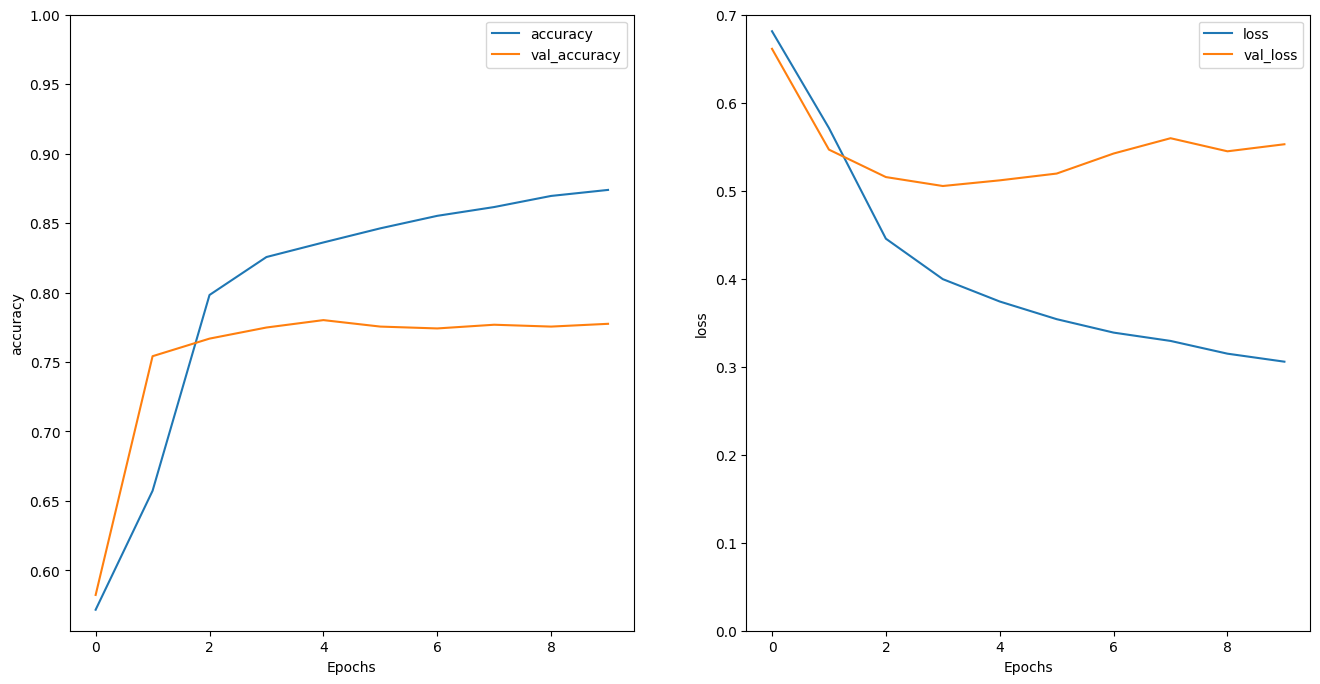

In [125]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(historyB, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(historyB, 'loss')
plt.ylim(0, None)

2.

### Model C: Using 2 stakced LSTM layers with cleaned text

In [126]:
X_clean = df_tweets['cleaned_text']
y = df_tweets['target']
X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size = 0.2, random_state=42)
#to numpy so it can be understood by the model
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

In [127]:
modelC = tf.keras.Sequential([
    clean_encoder,
    tf.keras.layers.Embedding(len(clean_encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

modelC.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [131]:
historyC = modelC.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val,y_val),
                    validation_steps=30)

test_loss, test_acc = modelC.evaluate(X_val,y_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7818 - loss: 0.5887
Test Loss: 0.5782445073127747
Test Accuracy: 0.7874749898910522


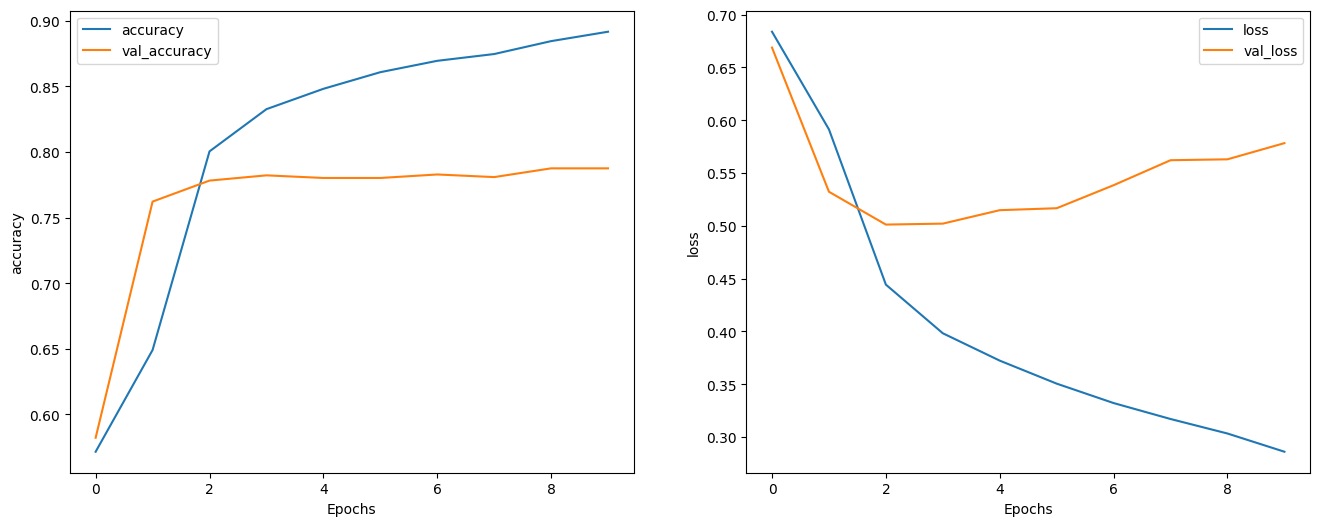

In [132]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(historyC, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(historyC, 'loss')

## Discussion & Conclusion
This project explored the use of Recurrent Neural Networks (RNNs), specifically LSTMs, to classify tweets as disaster-related or not. We built three models:

**Model A**: Utilized a pre-processed, "cleaned" version of the tweet text, removing stop words, special characters, and numbers.

**Model B**: Utilized the raw, uncleaned tweet text.

**Model C**: Similar to Model A, but employed two stacked Bidirectional LSTM layers for potentially capturing more complex patterns in the data.
We focused our analysis comparing Model A and Model C, both of which leverages the cleaned text.

Because Model A has a slight better performance than Model , we focused our analysis comparing Model A and Model C, both of which leverages the cleaned text with different architechtures.

### Comparing Model A and Model C

**Accuracy:** Both Model A and Model C achieve good accuracy. Based on the accuracy charts, Model A shows a steady increase in accuracy over the training epochs, while Model C tends to have slightly better performance throughout the training phase.

**Confusion Matrices:** The confusion matrices provide a detailed breakdown of the models' predictions. By visually inspecting the heatmaps, we can identify cases where the model correctly and incorrectly classifies disaster and non-disaster tweets.

**Complexity:** Model C, with its stacked LSTM layers, is inherently more complex than Model A. This added complexity might enable it to capture more nuanced relationships in the text data, potentially leading to better performance, however, could increase computational cost and require more time to train.

**Overfitting:** Observing the difference between training and validation accuracy, we can evaluate the presence of overfitting. The accuracy charts might show signs of overfitting as the validation accuracy might start to plateau or even decrease while training accuracy continues to improve. Early stopping can be implemented to help mitigate this issue.


From our analysis, **Model C with stacked LSTMs appears to have a slight edge in performance compared to Model A**. Although both models achieve good accuracy, Model C's deeper architecture might better handle the complexities of natural language understanding for this task.

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


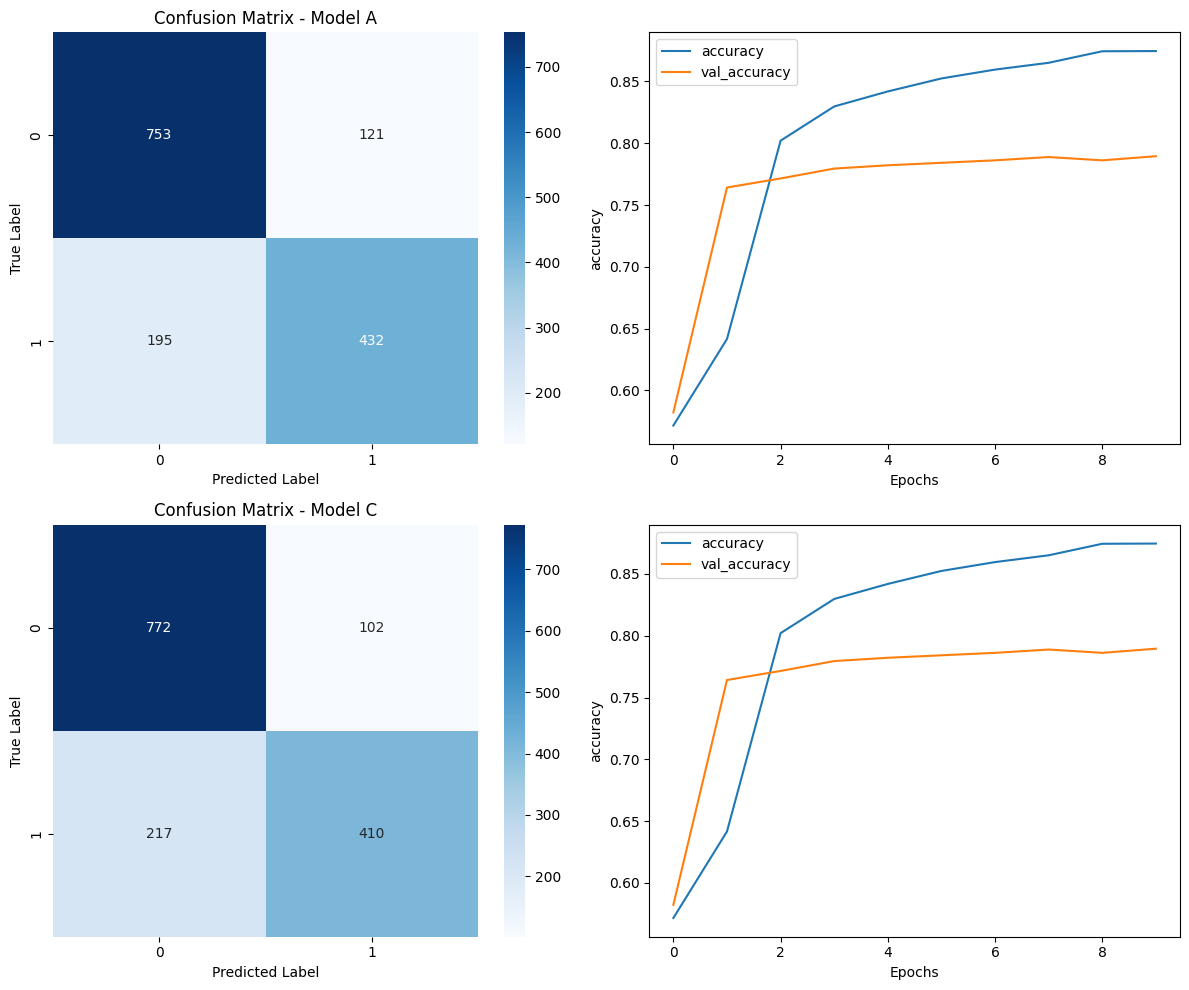

In [158]:
#plotting the confusion matrxi from modelA & ModelC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



predictionsA = modelA.predict(X_val)
predictionsA = (predictionsA > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

predictionsC = modelC.predict(X_val)
predictionsC = (predictionsC > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

# Generate confusion matrices
cmA = confusion_matrix(y_val, predictionsA)
cmC = confusion_matrix(y_val, predictionsC)

#accuracy charts

# Visualize the confusion matrices using seaborn heatmaps
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(cmA, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Model A")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(2, 2, 2)
plot_graphs(historyA, 'accuracy')

plt.subplot(2, 2, 3)
sns.heatmap(cmC, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Model C")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(2, 2, 4)
plot_graphs(historyA, 'accuracy')

plt.tight_layout()
plt.show()

### Further Considerations

**Hyperparameter Tuning:** The performance of both models can potentially be further improved by fine-tuning the hyperparameters, such as the number of LSTM units, dropout rate, learning rate, and batch size.

**Word Embeddings:** Exploring different word embedding techniques, such as Word2Vec or GloVe, could improve how the model represents the text data and might result in enhanced performance.

By following these improvement strategies and more in-depth experimentation, the models can potentially achieve even greater accuracy and robustness. These would allow us to determine if the improvements will surpass the computational time and cost required by Model C. This project demonstrates the effectiveness of RNNs for classifying disaster-related tweets and highlights potential avenues for further improvement and real-world application.

## References:
1. https://www.tensorflow.org/text/tutorials/text_classification_rnn
2. https://www.tensorflow.org/text/guide/word_embeddings
3. https://www.tensorflow.org/guide/keras/working_with_rnns
4. https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation
5. https://github.com/brucamail/MSCS-Machine-Learning/blob/main/CSCA5632/Airline%20Topic%20Modeling/Airline_Feedback_TopicModeling.ipynb

### Kaggle submission


In [159]:
#loading test data
df_test = pd.read_csv('test.csv')
#dropping irrelevant columns
df_test.drop(columns=['keyword','location'], inplace=True)

#cleaning text
df_test['cleaned_text'] = df_test['text'].apply(clean_text_spacy)

X_test = df_test['cleaned_text'].to_numpy()

#using Model C to predict X_test

test_predictions = modelC.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

#download test predictions id and target
submission = pd.DataFrame({'id': df_test['id'], 'target': test_predictions.flatten()})
submission.to_csv('my_submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
